In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from pylab import rcParams
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [4]:
#Loading the DataSet
data = pd.read_csv('/content/drive/MyDrive/timeseries_sales.csv')

**1.DATA PREPARATION**

***1.1 Analysing the Dataset***


In [5]:
# Getting first five rows of the Dataset
data.head(5)

,order_id,order_date,ship_date,ship_mode,customer_id,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales_$
0,CA-2017-152156,08/11/17,11/11/17,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,08/11/17,11/11/17,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,12/06/17,16/06/17,Second Class,DV-13045,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,11/10/16,18/10/16,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,11/10/16,18/10/16,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [ ]:
data.shape

In [ ]:
print(data.info())


In [6]:
# Getting the count of unique values for each column in the dataset
unique_counts = data.nunique()
print(unique_counts)


order_id        4922
order_date      1230
ship_date       1326
ship_mode          4
customer_id      793
country            1
city             529
state             49
postal_code      626
region             4
product_id      1861
category           3
sub_category      17
product_name    1849
sales_$         5757
dtype: int64


In [7]:
# Calculating the mean and median for the sales_$ column
mean_sales = data['sales_$'].mean()
median_sales = data['sales_$'].median()
print(f"Mean Sales: {mean_sales}")
print(f"Median Sales: {median_sales}")


Mean Sales: 230.7690594591837
Median Sales: 54.489999999999995


In [ ]:
data.isnull().sum()

In [8]:
# Handling null values
# Replacing the null values in postal_code column with the mode of the same column
data['postal_code'].fillna(data['postal_code'].mode()[0], inplace=True)

In [ ]:
print(data.isnull().sum())

In [9]:
# Date Format Conversion and Validation
# Function to convert date format from %d/%m/%y to %d-%m-%Y
def convert_date_format(date_str):
    try:
        # Check if date is in %d/%m/%y format
        date_obj = pd.to_datetime(date_str, format='%d/%m/%y', errors='coerce')
        if pd.notna(date_obj):
            return date_obj.strftime('%d-%m-%Y')
        else:
            # If parsing fails, try another format
            return pd.to_datetime(date_str, format='%d-%m-%Y', errors='coerce').strftime('%d-%m-%Y')
    except ValueError:
        return date_str

# Apply the function to 'order_date' and 'ship_date' columns
data['order_date'] = data['order_date'].apply(convert_date_format)
data['ship_date'] = data['ship_date'].apply(convert_date_format)

# Convert the columns to datetime format
data['order_date'] = pd.to_datetime(data['order_date'], format='%d-%m-%Y', errors='coerce')
data['ship_date'] = pd.to_datetime(data['ship_date'], format='%d-%m-%Y', errors='coerce')


In [21]:
#Extracting Date Features from order_date
data['day'] = data['order_date'].dt.day
data['month'] = data['order_date'].dt.month
data['year'] = data['order_date'].dt.year
data['day_of_week'] = data['order_date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

***1.2 Handling Outliers***



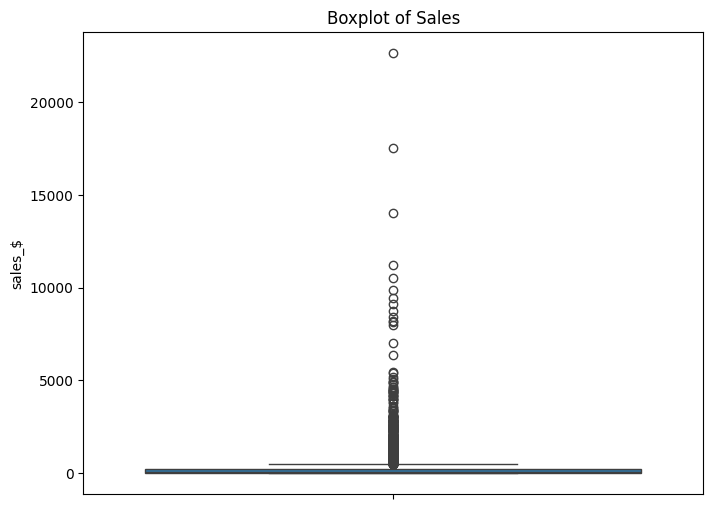

In [10]:
# Visualizing Sales Data with a Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(y='sales_$', data=data)
plt.title('Boxplot of Sales')
plt.ylabel('sales_$')
plt.show()

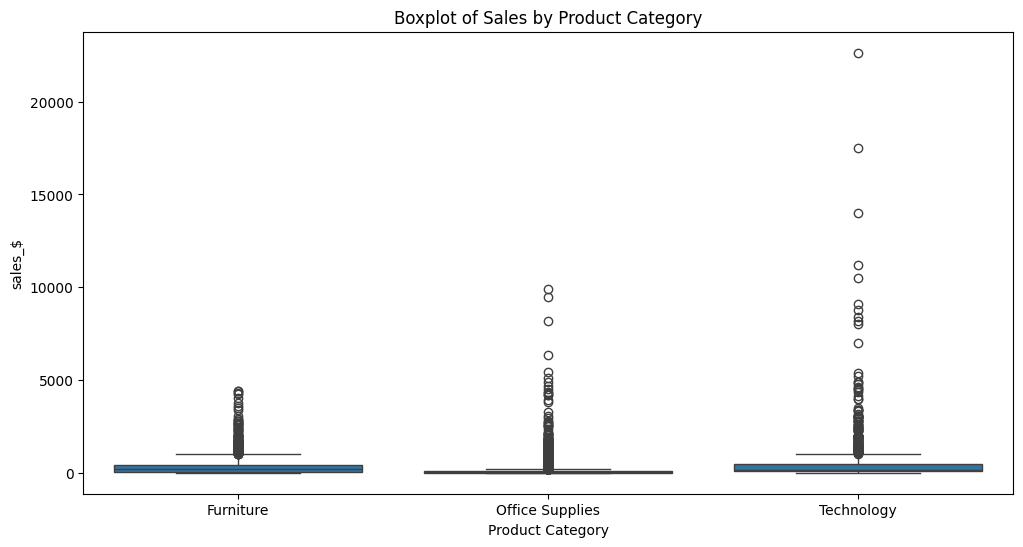

In [11]:
# Visualizing a boxplot for sales grouped by category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='sales_$', data=data)
plt.title('Boxplot of Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('sales_$')
plt.show()


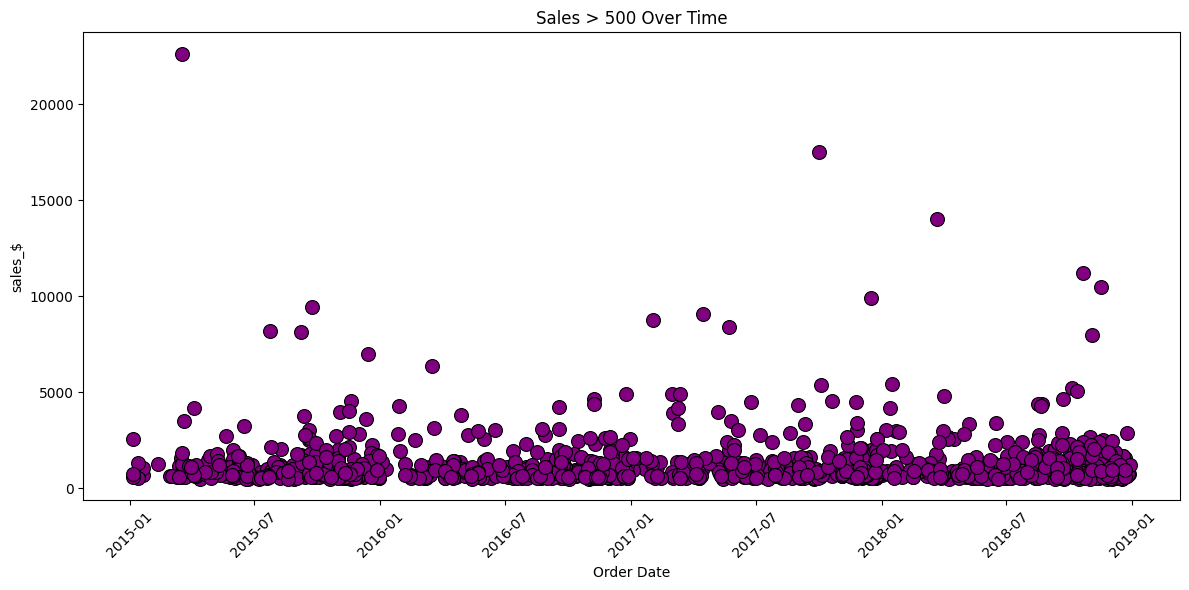

In [12]:
# Filtering sales values greater than 500
high_sales = data[data['sales_$'] > 500]

# Plotting the sales values greater than 500 against order_date
plt.figure(figsize=(12, 6))
sns.scatterplot(x='order_date', y='sales_$', data=high_sales, color='purple', s=100, edgecolor='black')

plt.title('Sales > 500 Over Time')
plt.xlabel('Order Date')
plt.ylabel('sales_$')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# Calculating the 99th percentile for the sales_$ column
percentile_99 = data['sales_$'].quantile(0.99)

# Filtering the data to remove values above the 99th percentile
cleaned_data = data[data['sales_$'] <= percentile_99]
print(f"99th Percentile of Sales: {percentile_99}")
print(f"Number of rows after removing values above the 99th percentile: {cleaned_data.shape[0]}")


99th Percentile of Sales: 2480.2078000000056
Number of rows after removing values above the 99th percentile: 9702


In [14]:
# Analyzing the removed rows
filtered_data = data[~data.index.isin(cleaned_data.index)]
print(filtered_data['sales_$'].describe())


count       98.000000
mean      4559.617449
std       3167.368525
min       2504.740000
25%       2800.950000
50%       3405.582000
75%       4620.052500
max      22638.480000
Name: sales_$, dtype: float64


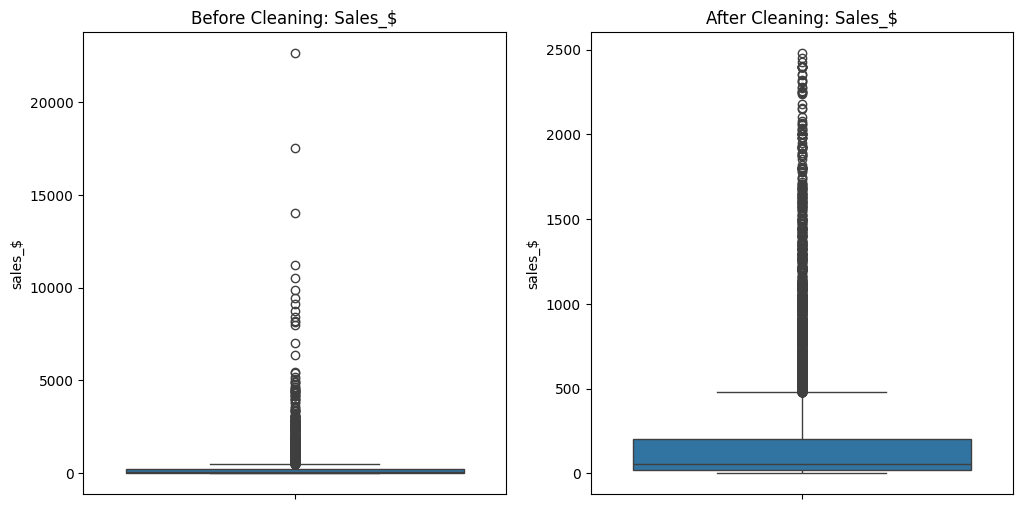

In [15]:
# Plotting before cleaning
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data['sales_$'])
plt.title('Before Cleaning: Sales_$')
# Plotting after cleaning
plt.subplot(1, 2, 2)
sns.boxplot(cleaned_data['sales_$'])
plt.title('After Cleaning: Sales_$')
plt.show()


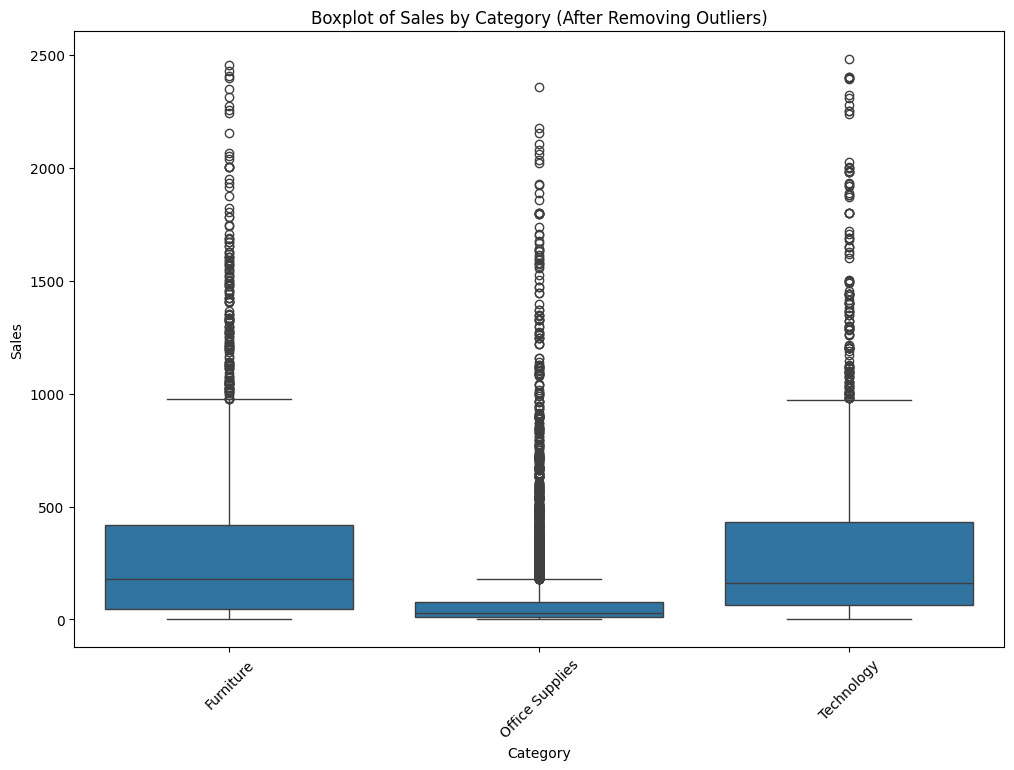

In [16]:
# Visualizing the boxplot for sales after removing outliers, categorized by 'category'
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='sales_$', data=cleaned_data)
plt.title('Boxplot of Sales by Category (After Removing Outliers)')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

In [17]:
data=cleaned_data
data.shape

(9702, 15)

**2.EXPLORATORY DATA ANALYSIS(EDA)**


***2.1 Visualizing sales over time***

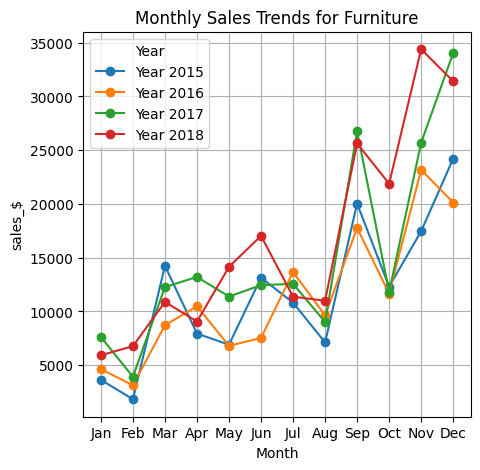

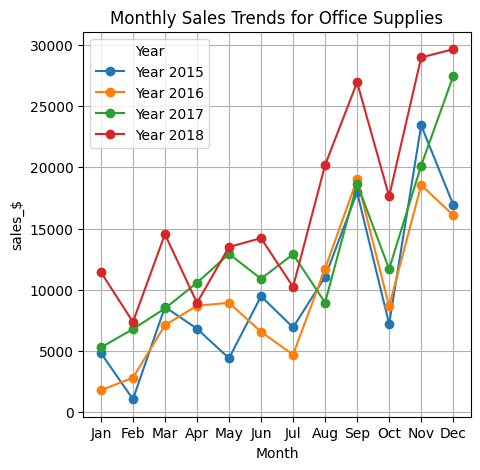

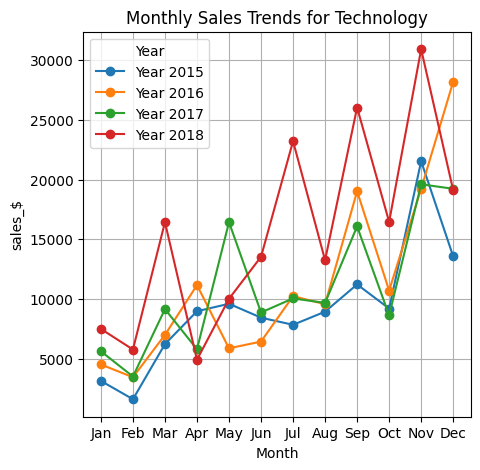

In [22]:
# Visualizing monthly sales of each category over year
# Getting unique categories
categories = data['category'].unique()

# Creating a figure for each category
for cat in categories:
    # Filtering data for the current category
    category_data = data[data['category'] == cat]

    # Aggregating log_sales by year and month
    monthly_sales = category_data.groupby(['year', 'month'])['sales_$'].sum().unstack(level=0)

    # Plotting the data
    plt.figure(figsize=(5, 5))

    # Plotting each year's sales data
    for year in monthly_sales.columns:
        plt.plot(monthly_sales.index, monthly_sales[year], marker='o', label=f'Year {year}')
    plt.xlabel('Month')
    plt.ylabel('sales_$')
    plt.title(f'Monthly Sales Trends for {cat}')
    plt.legend(title='Year')
    plt.grid(True)

    # Adjusting x-axis ticks for months
    if isinstance(category_data['month'].iloc[0], str):  # If month is a string
        plt.xticks(monthly_sales.index, monthly_sales.index, rotation=45)
    else:  # If month is numeric
        plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.show()


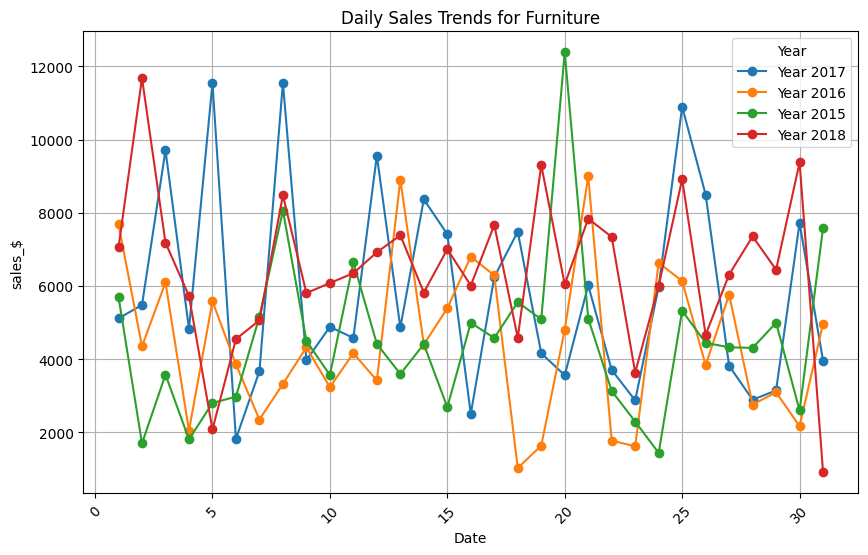

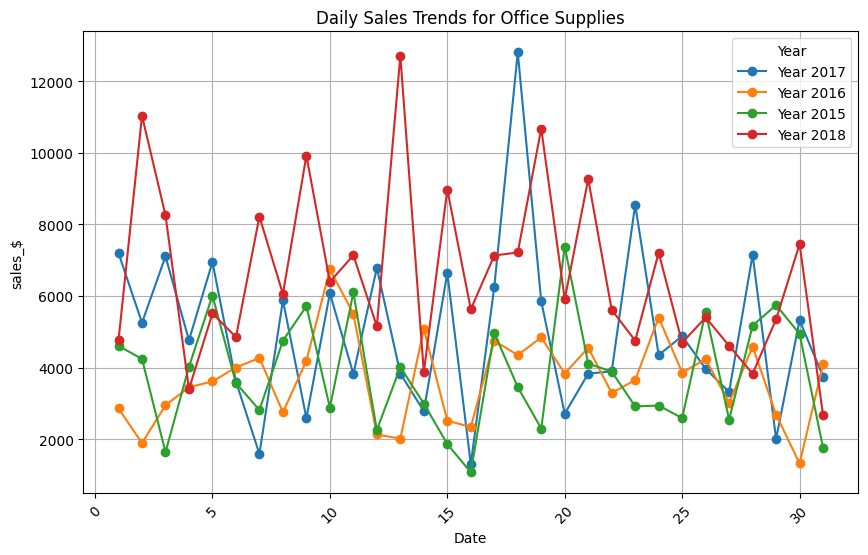

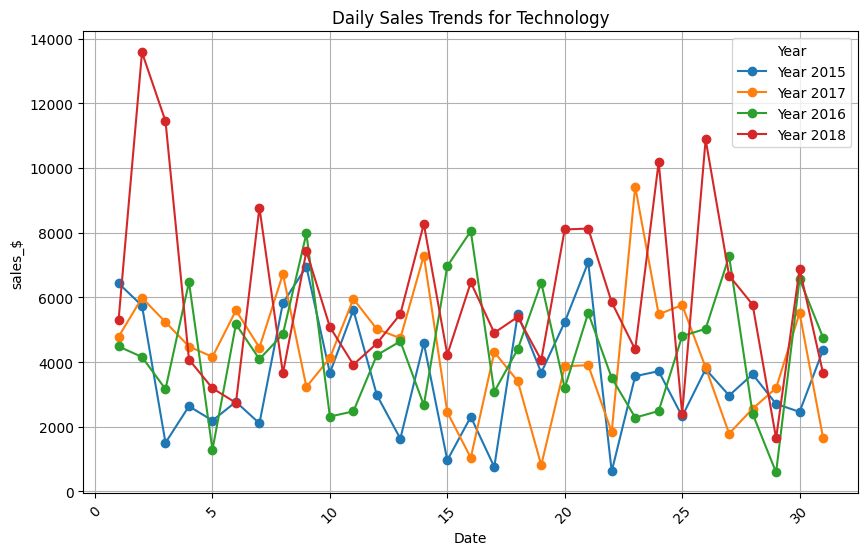

In [23]:
# Visualizing daily sales of each category over year
for cat in categories:
    # Filtering data for the current category
    category_data = data[data['category'] == cat]

    # Getting unique years for the current category
    years = category_data['year'].unique()

    # Creating a plot for the current category
    plt.figure(figsize=(10, 6))

    for year in years:
        # Filter data for the current year
        yearly_data = category_data[category_data['year'] == year]

        # Aggregating log_sales by date
        daily_sales = yearly_data.groupby('day')['sales_$'].sum()

        # Plotting the daily sales data
        plt.plot(daily_sales.index, daily_sales, marker='o', label=f'Year {year}')

    plt.xlabel('Date')
    plt.ylabel('sales_$')
    plt.title(f'Daily Sales Trends for {cat}')
    plt.legend(title='Year')
    plt.grid(True)
    plt.xticks(rotation=45)

    plt.show()

In [24]:
# order_date is set as the index
data['order_date'] = pd.to_datetime(data['order_date'], format='%d-%m-%Y', errors='coerce')
data.set_index('order_date', inplace=True)

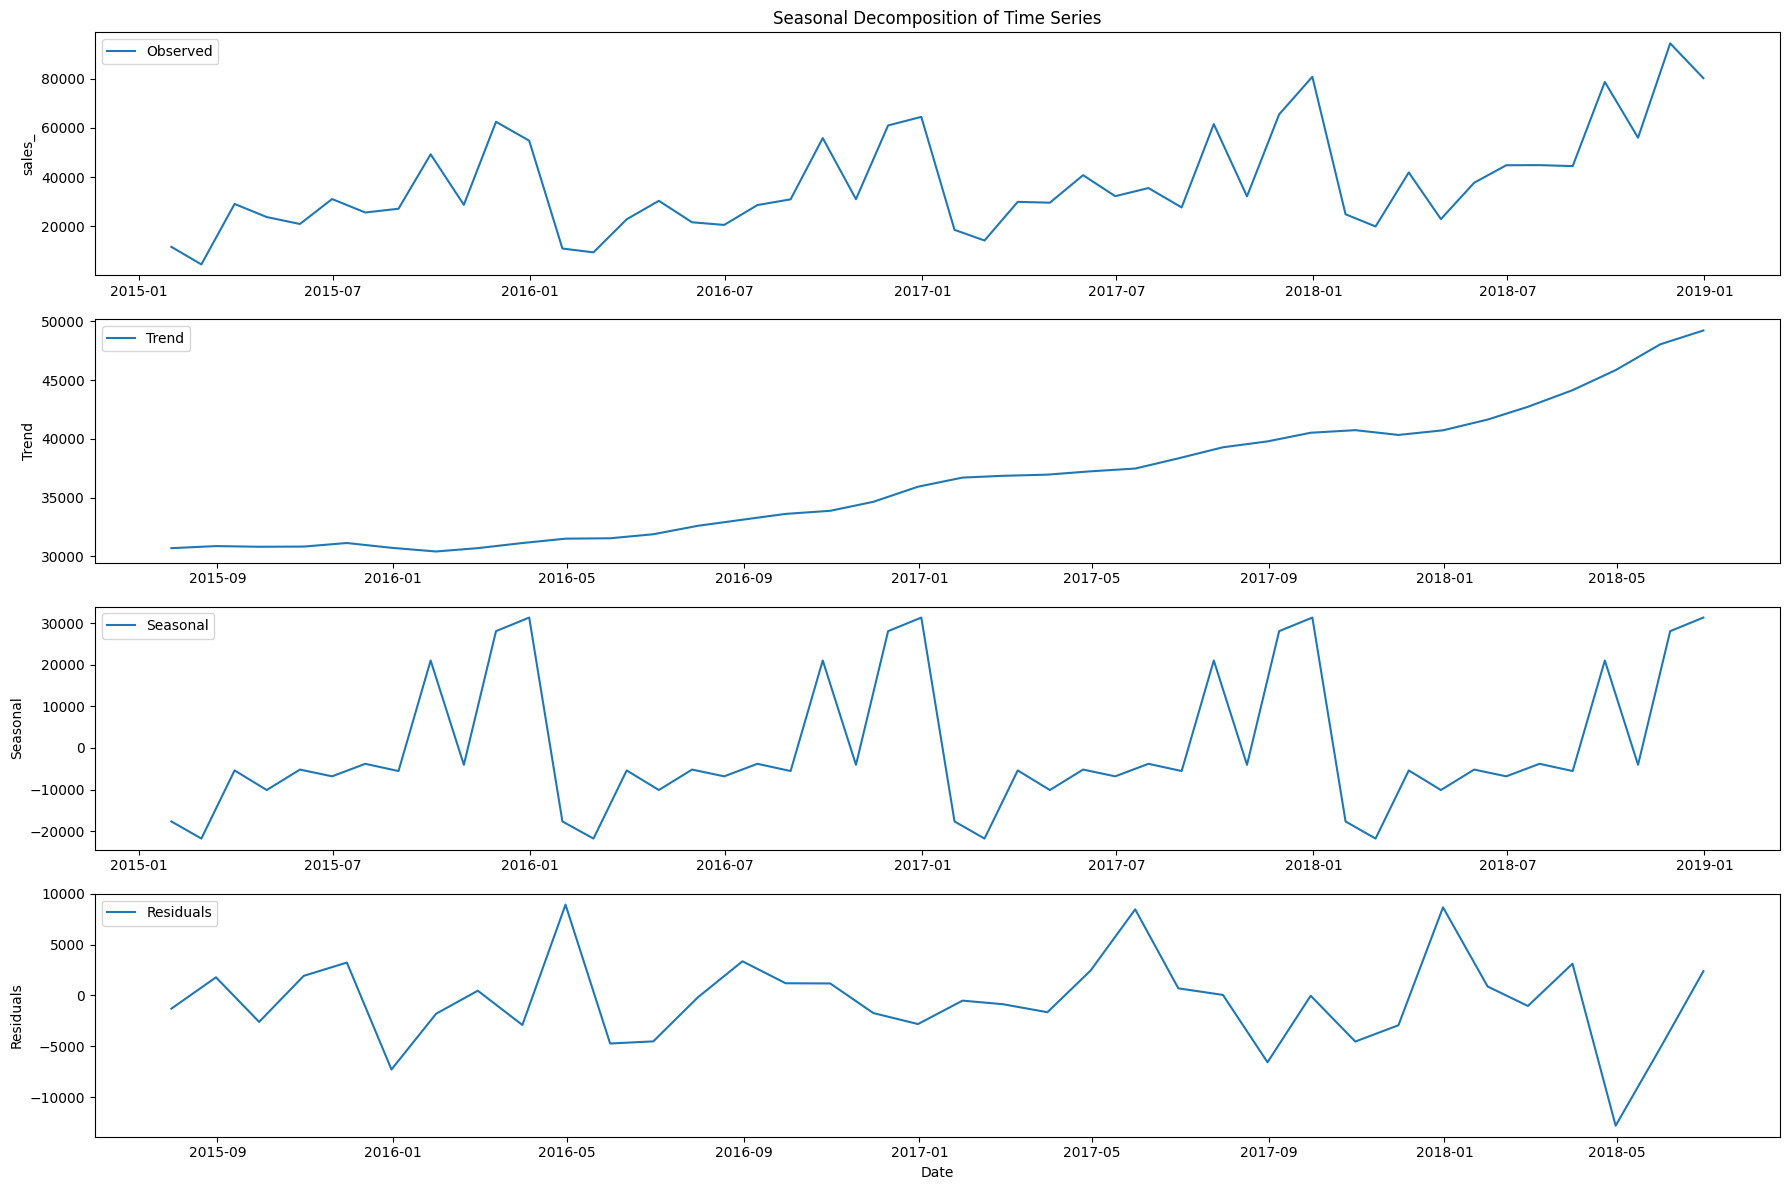

In [25]:
# Seasonal Decomposition
# Resampling the data to ensure consistent frequency
monthly_sales = data['sales_$'].resample('M').sum()
rcParams['figure.figsize'] = 18, 8

# Decomposing the time series
decomposition = sm.tsa.seasonal_decompose(monthly_sales, model='additive', period=12)
# Creating individual plots for each component to ensure visibility
plt.figure(figsize=(18, 12))

# Plotting Observed
plt.subplot(4, 1, 1)
plt.plot(monthly_sales, label='Observed')
plt.legend(loc='upper left')
plt.title('Seasonal Decomposition of Time Series')
plt.ylabel('sales_')

# Plotting Trend
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.ylabel('Trend')

# Plotting Seasonal
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.ylabel('Seasonal')

# Plotting Residuals
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')
plt.ylabel('Residuals')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


**3.FEATURE ENGINEERING**


***3.1 Aggregating sales over different columns***


In [26]:
# Grouping by order_date, category, sub_category, and state, aggregating sales_$
sales_data = data.groupby(['order_date', 'category', 'sub_category','state'])[['sales_$']].sum().reset_index()


In [28]:
# Extracting month, day, and year from the order_date
sales_data['month'] = sales_data['order_date'].dt.month
sales_data['day'] = sales_data['order_date'].dt.day
sales_data['year'] = sales_data['order_date'].dt.year
sales_data['day_of_week'] = sales_data['order_date'].dt.dayofweek
sales_data['is_weekend'] = sales_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
sales_data.shape

***3.2 Adding additional features***





In [27]:
#Adding lagged features
# Defining the lags in days
lags = [1, 7,15,30,90,180,270,365]

# Creating lagged features for each specified lag (1 day, 7 days, 30 days,365 days)
for lag in lags:
    sales_data[f'sales_lag_{lag}'] = sales_data.groupby('category')['sales_$'].shift(lag)
# Handling NaN values in lagged columns
sales_data.fillna({'sales_lag_1': 0, 'sales_lag_7': 0, 'sales_lag_30': 0, 'sales_lag_365': 0,'sales_lag_15': 0,'sales_lag_30': 0,'sales_lag_180': 0,'sales_lag_270': 0,'sales_lag_90': 0}, inplace=True)

In [29]:
#Adding LFL growth
sales_data['LFL_growth'] = (sales_data['sales_$'] - sales_data['sales_lag_365']) / sales_data['sales_lag_365'] * 100
#Handling NaN and inf values in LFL growth column
sales_data['LFL_growth'] = sales_data['LFL_growth'].replace([np.inf, -np.inf], np.nan).fillna(0)


In [ ]:
sales_data['sales_$']

In [30]:
# List of moving average windows
windows = [3, 7, 15, 30, 90, 180,270,365]

# Adding moving averages
for window in windows:
    sales_data[f'moving_avg_{window}'] = sales_data.groupby('category')['sales_$'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())

# Adding 30-day moving average for the same period last year
sales_data['moving_avg_30_last_year'] = sales_data.groupby('category')['sales_$'].transform(lambda x: x.shift(365).rolling(window=30, min_periods=1).mean())
# Handling NaN values in moving averages columns
moving_avg_columns = [
    'moving_avg_3', 'moving_avg_7', 'moving_avg_15', 'moving_avg_30',
    'moving_avg_90', 'moving_avg_180', 'moving_avg_365', 'moving_avg_270',
    'moving_avg_30_last_year'
]
sales_data[moving_avg_columns] = sales_data[moving_avg_columns].fillna(0)


In [31]:
# Calculating exponential moving average (EMA)
spans = [3, 7, 15, 30, 90, 180,270,365]
for span in spans:
    sales_data[f'ema_{span}'] = sales_data.groupby('category')['sales_$'].transform(
        lambda x: x.shift(1).ewm(span=span, adjust=False).mean())
# Handling NaN values in EMA columns
for span in spans:
    sales_data[f'ema_{span}'].fillna(0, inplace=True)

In [ ]:
sales_data['ema_3']

In [32]:
# Adding day of the week indicators
sales_data['day_of_week'] = sales_data['order_date'].dt.dayofweek
sales_data = pd.get_dummies(sales_data, columns=['day_of_week'], prefix='day_of_week', drop_first=True)

# Adding month and day indicators
sales_data['month'] = sales_data['order_date'].dt.month
sales_data['day'] = sales_data['order_date'].dt.day

# Creating holiday indicators (example: using public holidays in the US)
from pandas.tseries.holiday import USFederalHolidayCalendar

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=sales_data['order_date'].min(), end=sales_data['order_date'].max())
sales_data['is_holiday'] = sales_data['order_date'].isin(holidays).astype(int)

# Adding a feature for the start of the month
sales_data['start_of_month'] = (sales_data['order_date'].dt.is_month_start).astype(int)

# Adding a feature for the end of the month
sales_data['end_of_month'] = (sales_data['order_date'].dt.is_month_end).astype(int)

In [33]:
sales_data.isna().sum()

,0
order_date,0
category,0
sub_category,0
state,0
sales_$,0
sales_lag_1,0
sales_lag_7,0
sales_lag_15,0
sales_lag_30,0
sales_lag_90,0


In [ ]:
sales_data.head(5)

***3.3 Feature Importance***




In [34]:
# Creating a label encoder object
label_encoder = LabelEncoder()
# Applying label encoding to categorical columns
sales_data['category'] = label_encoder.fit_transform(sales_data['category'])
sales_data['state'] = label_encoder.fit_transform(sales_data['state'])
sales_data['sub_category'] = label_encoder.fit_transform(sales_data['sub_category'])

In [35]:
# Computing the correlation matrix
correlation_matrix = sales_data.corr()
# Extracting the correlation of each column with 'sales'
correlation_with_sales = correlation_matrix['sales_$']
# Printing the correlations
print(correlation_with_sales)

order_date                -0.001296
category                  -0.017089
sub_category               0.103042
state                      0.001399
sales_$                    1.000000
sales_lag_1                0.104393
sales_lag_7                0.119801
sales_lag_15               0.106318
sales_lag_30               0.097281
sales_lag_90               0.111896
sales_lag_180              0.105932
sales_lag_270              0.079283
sales_lag_365              0.079344
month                      0.032272
day                        0.005871
year                      -0.009308
is_weekend                -0.007399
LFL_growth                 0.342569
moving_avg_3               0.145883
moving_avg_7               0.210400
moving_avg_15              0.257358
moving_avg_30              0.284478
moving_avg_90              0.308730
moving_avg_180             0.317114
moving_avg_270             0.318865
moving_avg_365             0.320025
moving_avg_30_last_year    0.193877
ema_3                      0

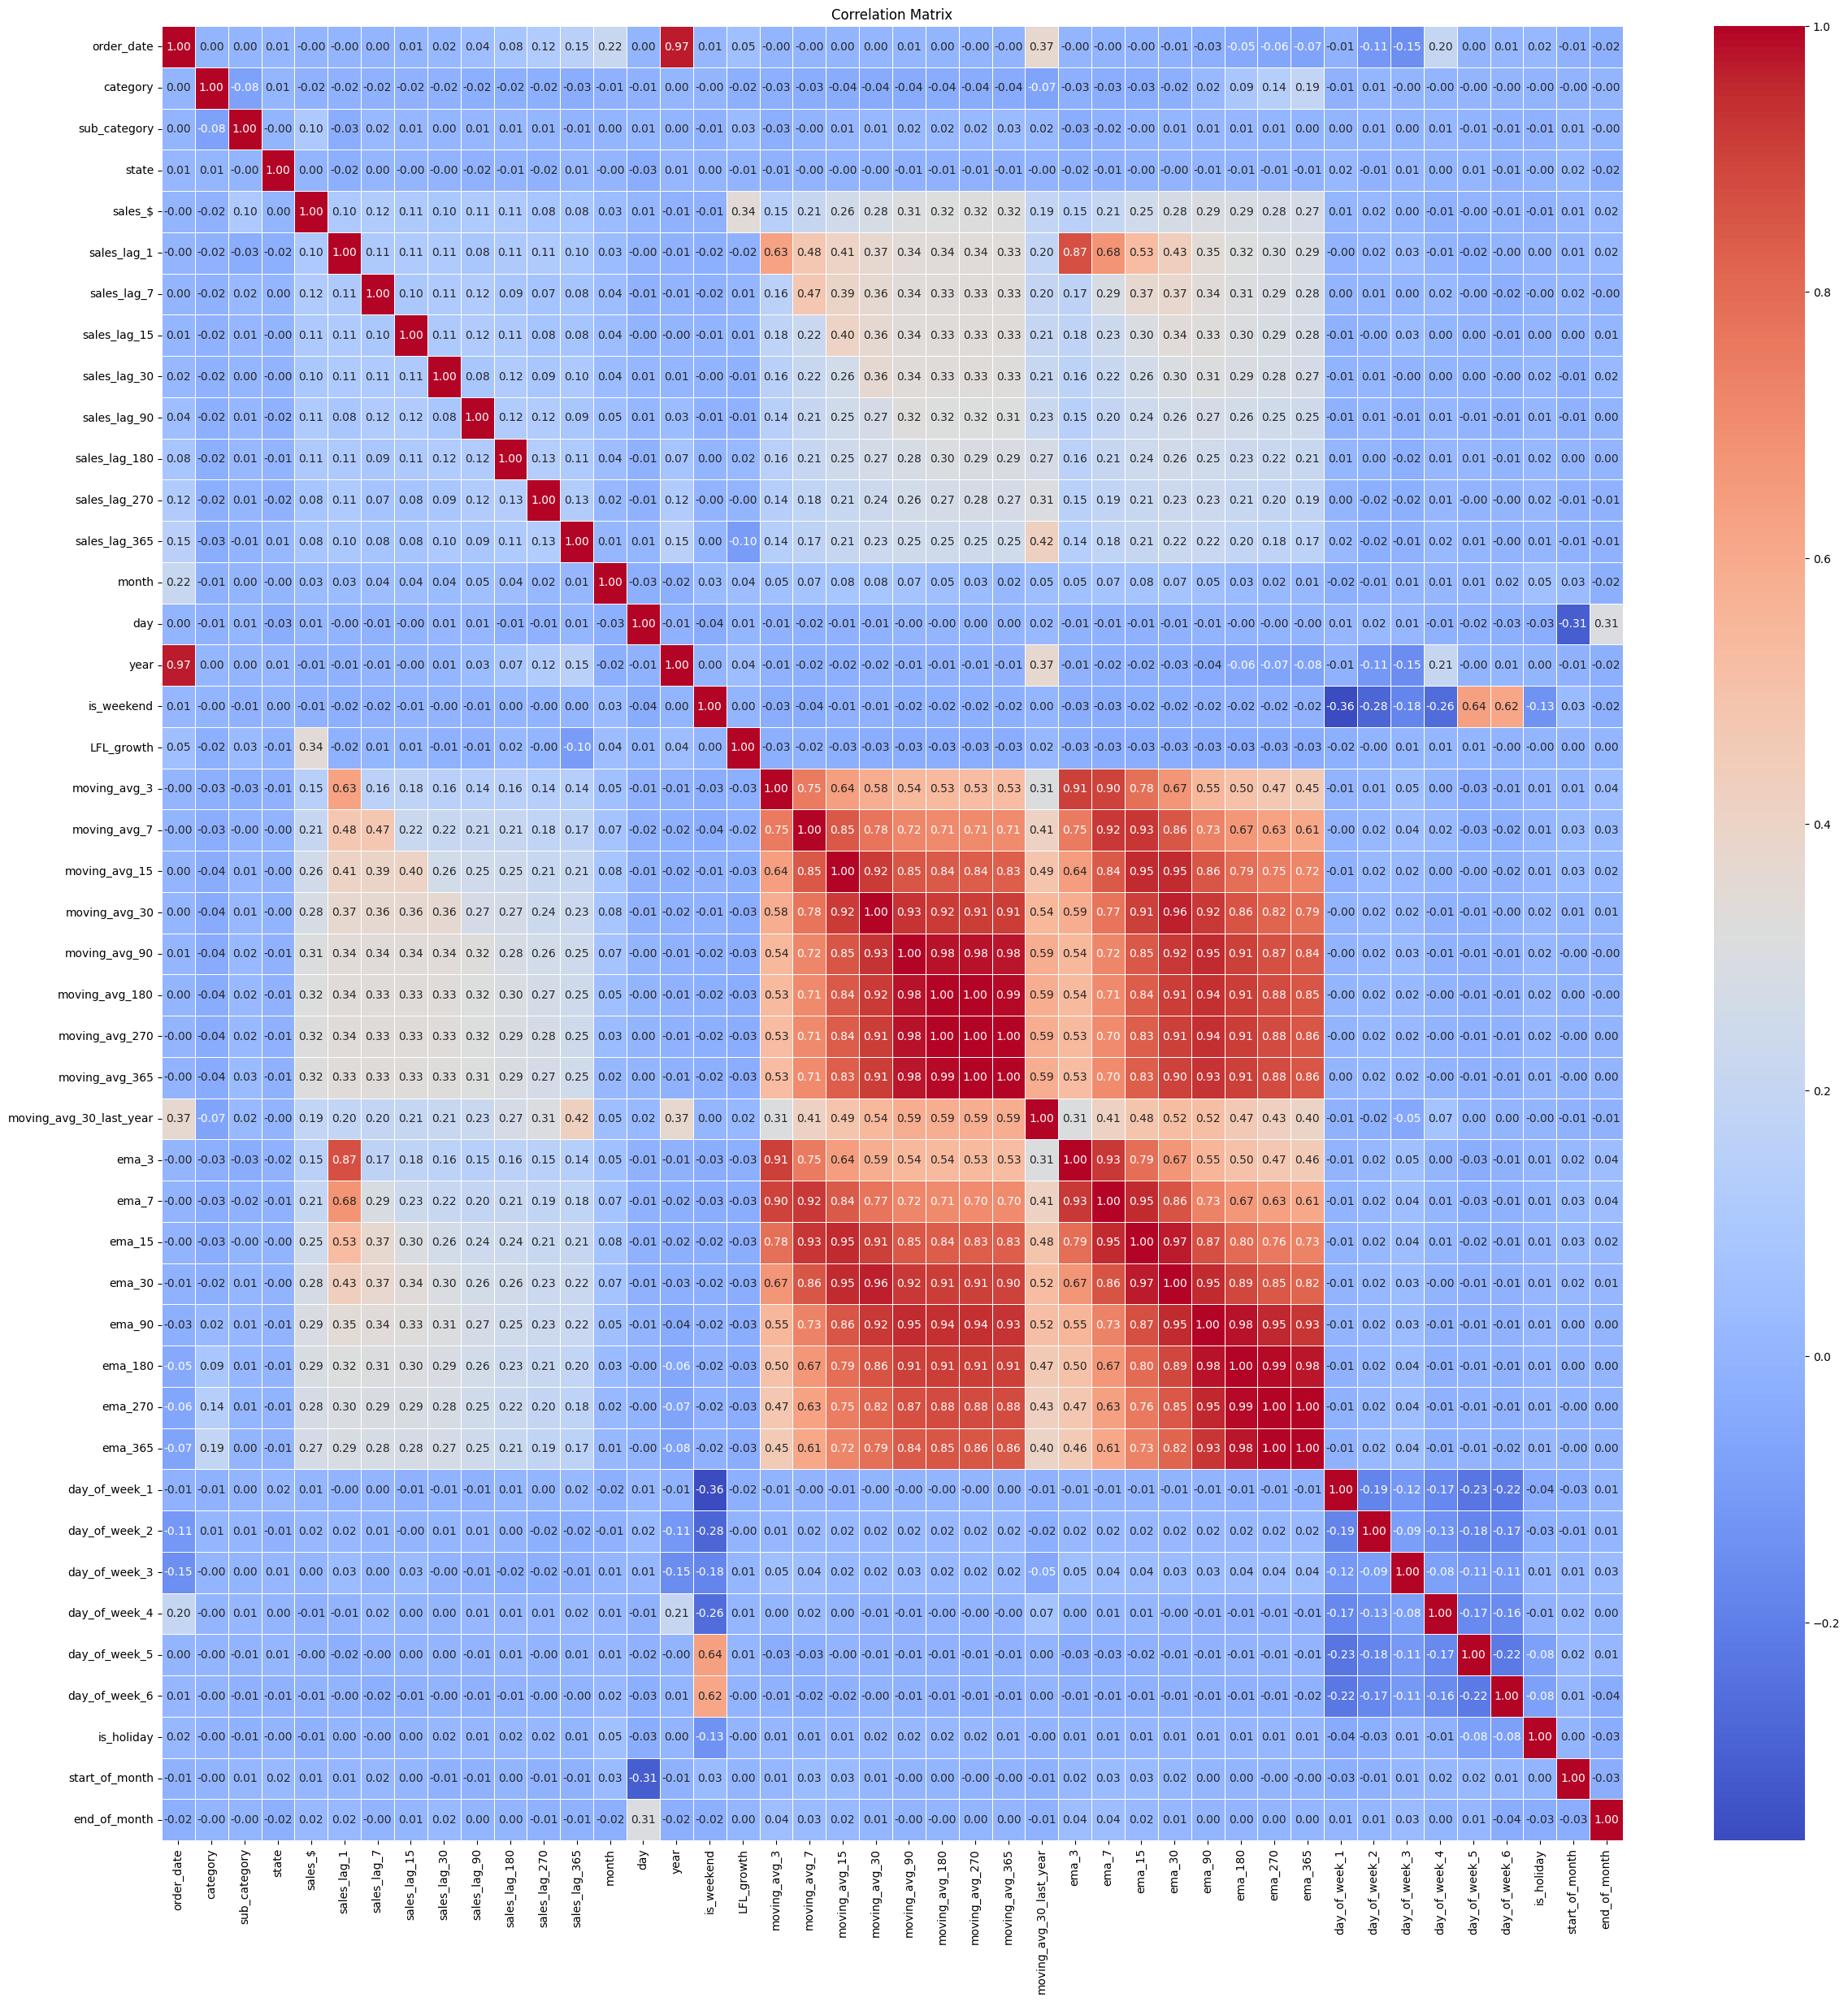

In [36]:
#Visualizing correlation matrix
correlation_matrix = sales_data.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(29, 29))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [37]:
# Checking for infinite values in the DataFrame
inf_counts = np.isinf(sales_data).sum()
print(inf_counts)


order_date                 0
category                   0
sub_category               0
state                      0
sales_$                    0
sales_lag_1                0
sales_lag_7                0
sales_lag_15               0
sales_lag_30               0
sales_lag_90               0
sales_lag_180              0
sales_lag_270              0
sales_lag_365              0
month                      0
day                        0
year                       0
is_weekend                 0
LFL_growth                 0
moving_avg_3               0
moving_avg_7               0
moving_avg_15              0
moving_avg_30              0
moving_avg_90              0
moving_avg_180             0
moving_avg_270             0
moving_avg_365             0
moving_avg_30_last_year    0
ema_3                      0
ema_7                      0
ema_15                     0
ema_30                     0
ema_90                     0
ema_180                    0
ema_270                    0
ema_365       

In [38]:
columns = ', '.join(sales_data.columns)
print(columns)


order_date, category, sub_category, state, sales_$, sales_lag_1, sales_lag_7, sales_lag_15, sales_lag_30, sales_lag_90, sales_lag_180, sales_lag_270, sales_lag_365, month, day, year, is_weekend, LFL_growth, moving_avg_3, moving_avg_7, moving_avg_15, moving_avg_30, moving_avg_90, moving_avg_180, moving_avg_270, moving_avg_365, moving_avg_30_last_year, ema_3, ema_7, ema_15, ema_30, ema_90, ema_180, ema_270, ema_365, day_of_week_1, day_of_week_2, day_of_week_3, day_of_week_4, day_of_week_5, day_of_week_6, is_holiday, start_of_month, end_of_month


In [39]:
# Feature Selection Using PCA
features = features = [ 'category', 'sub_category', 'state', 'sales_$', 'month', 'day', 'year', 'is_weekend',
           'sales_lag_1', 'sales_lag_7', 'sales_lag_15', 'sales_lag_30', 'sales_lag_90', 'sales_lag_180',
           'sales_lag_270', 'sales_lag_365', 'LFL_growth', 'moving_avg_3', 'moving_avg_7', 'moving_avg_15',
           'moving_avg_30', 'moving_avg_90', 'moving_avg_180', 'moving_avg_270', 'moving_avg_365',
           'moving_avg_30_last_year', 'ema_3', 'ema_7', 'ema_15', 'ema_30', 'ema_90', 'ema_180', 'ema_270',
           'ema_365', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
           'day_of_week_6', 'is_holiday', 'start_of_month', 'end_of_month'
]


# Extracting features from sales_data
X = sales_data[features]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=len(features))
pca.fit(X_scaled)

# Creating a DataFrame to store explained variance
explained_variance = pd.Series(pca.explained_variance_ratio_, index=features)

# Getting top features based on explained variance
top_10_features = explained_variance.nlargest(15).index.tolist()
top_5_features = explained_variance.nlargest(5).index.tolist()

print("Top 10 Features:")
print(top_10_features)

print("\nTop 5 Features:")
print(top_5_features)

print("\nExplained Variance Ratio:")
print(explained_variance)


Top 10 Features:
['category', 'sub_category', 'state', 'sales_$', 'month', 'day', 'year', 'is_weekend', 'sales_lag_1', 'sales_lag_7', 'sales_lag_15', 'sales_lag_30', 'sales_lag_90', 'sales_lag_180', 'sales_lag_270']

Top 5 Features:
['category', 'sub_category', 'state', 'sales_$', 'month']

Explained Variance Ratio:
category                   3.331424e-01
sub_category               5.283578e-02
state                      5.000578e-02
sales_$                    3.972614e-02
month                      3.409893e-02
day                        3.161310e-02
year                       2.842549e-02
is_weekend                 2.807839e-02
sales_lag_1                2.716984e-02
sales_lag_7                2.611845e-02
sales_lag_15               2.513846e-02
sales_lag_30               2.418005e-02
sales_lag_90               2.330280e-02
sales_lag_180              2.263686e-02
sales_lag_270              2.202591e-02
sales_lag_365              2.172667e-02
LFL_growth                 2.169575e-02
mo

 **4.MODEL BUILDING**

***4.1 XgBoost***

*4.1.1 Applying XgBoost for sales_data*

In [60]:
split_date = '2018-09-01'
# Splitting the data into training and testing sets
train_data = sales_data[sales_data['order_date'] < split_date]
test_data = sales_data[sales_data['order_date'] >= split_date]


In [61]:
# Converting the DataFrame to NumPy arrays
train = train_data[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values
test = test_data[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values

# Separating the features (X) and target (y) for train and test
trainX, trainy = train[:, :-1], train[:, -1]
testX, testy = test[:, :-1], test[:, -1]

In [68]:
# Fitting the model using XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.2, max_depth=6)

# Training the model
model.fit(trainX, trainy)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [69]:
# Make predictions on the test set
y_pred = model.predict(testX)
mae = mean_absolute_error(testy, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy, y_pred, squared=False)
print(f" RMSE: {rmse}")

Mean Absolute Error (MAE): 28.366850992566146
 RMSE: 76.89681749570681


In [70]:
# Get feature importance
importance = model.feature_importances_

# List of features
features = ['category', 'sub_category', 'state', 'sales_$', 'month', 'day', 'year', 'is_weekend',
           'sales_lag_1', 'sales_lag_7', 'sales_lag_15', 'sales_lag_30', 'sales_lag_90', 'sales_lag_180',
           'sales_lag_270', 'sales_lag_365', 'LFL_growth', 'moving_avg_3', 'moving_avg_7', 'moving_avg_15',
           'moving_avg_30', 'moving_avg_90', 'moving_avg_180', 'moving_avg_270', 'moving_avg_365',
           'moving_avg_30_last_year', 'ema_3', 'ema_7', 'ema_15', 'ema_30', 'ema_90', 'ema_180', 'ema_270',
           'ema_365', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
           'day_of_week_6', 'is_holiday', 'start_of_month', 'end_of_month']

# Sort feature importance
sorted_indices = np.argsort(importance)[::-1]

# Print feature importance scores
for i in sorted_indices:
    print(f"{features[i]}: {importance[i]:.4f}")

sales_lag_30: 0.3526
sales_lag_7: 0.3120
sales_lag_90: 0.0963
month: 0.0896
year: 0.0271
is_weekend: 0.0208
state: 0.0186
sales_lag_1: 0.0173
day: 0.0152
sub_category: 0.0145
sales_lag_15: 0.0140
sales_$: 0.0100
sales_lag_180: 0.0063
category: 0.0057


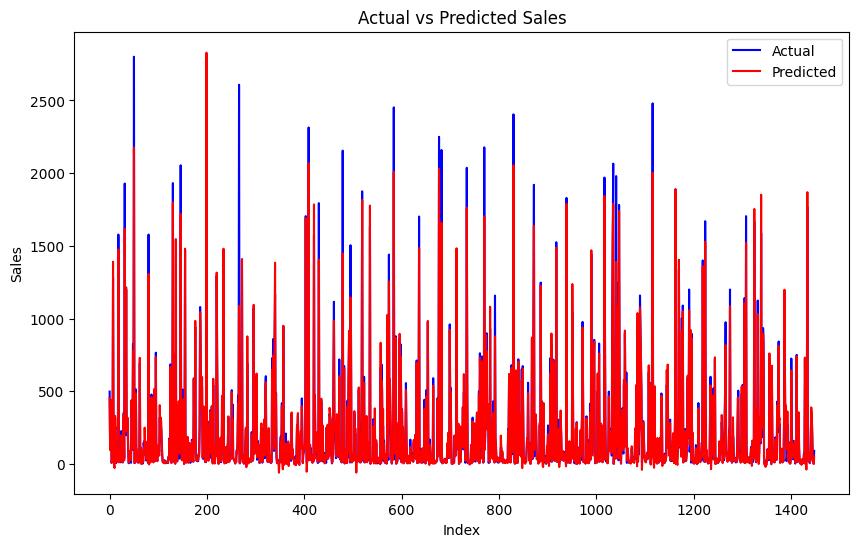

In [71]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(testy, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.show()


(115, 6)


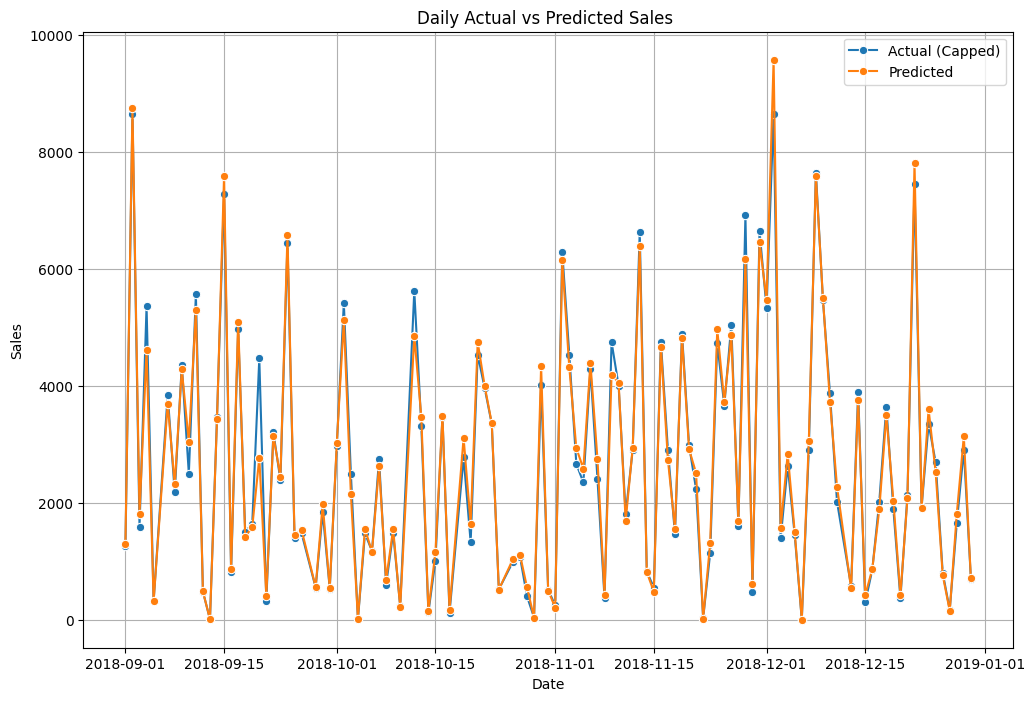

In [66]:
# Creating a DataFrame with daily actual and predicted sales
test_results = pd.DataFrame({
    'Actual': test_data['sales_$'],
    'Predicted': y_pred,
    'year': test_data['order_date'].dt.year,
    'month': test_data['order_date'].dt.month,
    'day': test_data['order_date'].dt.day
})

# Grouping by year, month, and day, and sum the actual and predicted sales
daily_sales = test_results.groupby(['year', 'month', 'day']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Creating a capped version of Actual without changing the data scale
second_max_value = daily_sales['Actual'].nlargest(2).iloc[-1]
daily_sales['Actual_capped'] = daily_sales['Actual'].clip(upper=second_max_value)

print(daily_sales.shape)

# Creating a date column for plotting
daily_sales['date'] = pd.to_datetime(daily_sales[['year', 'month', 'day']])

# Plotting daily actual vs predicted sales
plt.figure(figsize=(12, 8))
sns.lineplot(data=daily_sales, x='date', y='Actual_capped', label='Actual (Capped)', marker='o')
sns.lineplot(data=daily_sales, x='date', y='Predicted', label='Predicted', marker='o')

plt.title('Daily Actual vs Predicted Sales ')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


Forecasting next 90 days sales for combined model

In [72]:
# Function to predict for each category and update the DataFrame iteratively
def predict_and_update(category, category_name, days_to_predict):
    # Filter the test data for the given category
    category_test_df = test_data[test_data['category'] == category][['day_of_week_2', 'category',
        'moving_avg_180', 'ema_3', 'moving_avg_365', 'ema_15', 'ema_180', 'moving_avg_90',
        'sales_lag_1', 'sales_lag_365', 'moving_avg_15', 'LFL_growth', 'sub_category', 'day_of_week_4', 'sales_$']]

    # Map for current day of the week to column name
    day_of_week_columns = ['day_of_week_2', 'day_of_week_4']  # Adjust based on your data
    day_of_week_map = {0: 'day_of_week_2', 3: 'day_of_week_4'}  # Adjust as necessary
    inverse_day_of_week_map = {v: k for k, v in day_of_week_map.items()}

    # List to store predictions
    predictions = []

    # Get the current day of the week (from the last row in the DataFrame)
    current_day_of_week_col = category_test_df[day_of_week_columns].iloc[-1].idxmax()
    current_day_of_week_num = inverse_day_of_week_map[current_day_of_week_col]  # Find current day as a number

    # Loop over each day to predict iteratively
    for day in range(1, days_to_predict + 1):
        # Prepare the data for prediction (use the last row in category_test_df as input, excluding 'sales_$')
        current_test_data = category_test_df.iloc[-1, :-1].values  # Exclude 'sales_$'

        # Predict the next day's sales using the model
        current_pred = model.predict(current_test_data.reshape(1, -1))[0]

        # Ensure sales predictions are non-negative
        if current_pred < 0:
            current_pred = 0  # Set negative sales to 0 or any minimum threshold

        # Append the prediction to the list
        predictions.append(current_pred)

        # Create a new row for the predicted day
        new_row = category_test_df.iloc[-1].copy()
        new_row['sales_$'] = current_pred

        # Increment the day of the week cyclically
        current_day_of_week_num = (current_day_of_week_num + 1) % 7

        # Reset all day_of_week columns to 0
        new_row[day_of_week_columns] = 0

        # Set the correct day_of_week column to 1
        if current_day_of_week_num in day_of_week_map:
            new_row[day_of_week_map[current_day_of_week_num]] = 1

        # Append the new row to the DataFrame
        category_test_df = pd.concat([category_test_df, pd.DataFrame([new_row])], ignore_index=True)

        # Recalculate the lag features after appending the new data
        category_test_df['sales_lag_1'] = category_test_df['sales_$'].shift(1)
        category_test_df['sales_lag_365'] = category_test_df['sales_$'].shift(365) if len(category_test_df) > 365 else np.nan

        # Recalculate moving averages based on the newly appended data
        category_test_df['moving_avg_180'] = category_test_df['sales_$'].rolling(window=180).mean() if len(category_test_df) >= 180 else np.nan
        category_test_df['moving_avg_90'] = category_test_df['sales_$'].rolling(window=90).mean() if len(category_test_df) >= 90 else np.nan
        category_test_df['moving_avg_15'] = category_test_df['sales_$'].rolling(window=15).mean() if len(category_test_df) >= 15 else np.nan
        category_test_df['moving_avg_365'] = category_test_df['sales_$'].rolling(window=365).mean() if len(category_test_df) >= 365 else np.nan

        # Recalculate exponential moving averages (EMAs) based on the newly appended data
        category_test_df['ema_3'] = category_test_df['sales_$'].ewm(span=3).mean() if len(category_test_df) >= 3 else np.nan
        category_test_df['ema_15'] = category_test_df['sales_$'].ewm(span=15).mean() if len(category_test_df) >= 15 else np.nan
        category_test_df['ema_180'] = category_test_df['sales_$'].ewm(span=180).mean() if len(category_test_df) >= 180 else np.nan

    # Return the predictions for the category
    print(f"Predictions for {category_name}: {predictions}")
    return predictions


# Predict for Furniture (category = 0)
furniture_predictions = predict_and_update(0, "Furniture", days_to_predict=90)
# Predict for Technology (category = 1)
technology_predictions = predict_and_update(1, "Technology", days_to_predict=90)

# Predict for Office (category = 2)
office_predictions = predict_and_update(2, "Office", days_to_predict=90)


Predictions for Furniture: [348.01007, 1738.386, 1744.9155, 1848.8295, 1648.445, 1740.8186, 1738.7937, 1681.3477, 1670.7423, 1656.9379, 1637.3145, 1656.9379, 1658.2661, 1656.9379, 1693.2402, 1695.1672, 1695.1672, 1675.5438, 1695.1672, 1705.5726, 1705.5726, 1703.6456, 1705.5726, 1705.5726, 1685.9492, 1705.5726, 1705.5726, 1643.3623, 1645.4756, 1644.6906, 1644.6906, 1625.0671, 1644.6906, 1644.6906, 1644.6906, 1646.9042, 1644.6906, 1659.8687, 1640.2452, 1659.4236, 1659.8687, 1659.4236, 1657.652, 1659.4236, 1659.4236, 1639.8002, 1659.4236, 1659.8687, 583.84796, 129.6131, 373.72153, 1600.5614, 192.50156, 225.11278, 115.46175, 237.0796, 498.9342, 378.4975, 398.64465, 133.26254, 1213.4669, 458.5131, 1711.8824, 203.05927, 303.387, 269.86685, 142.1915, 306.7076, 288.75925, 59.283894, 1028.8275, 617.6074, 201.41379, 61.595634, 117.48232, 154.04128, 683.1125, 1710.1859, 231.21567, 221.37515, 80.34179, 748.74445, 183.75816, 841.6726, 181.42554, 252.13113, 1069.2893, 765.3167, 864.0589, 749.9393]
P

In [40]:
# Creating separate DataFrames for each category
furniture_df = sales_data[sales_data['category'] == 0]
technology_df = sales_data[sales_data['category'] == 1]
office_df = sales_data[sales_data['category'] == 2]


*4.1.2 Applying XgBoost for Furniture DataSet*

In [41]:
split_date = '2018-09-01'
# Splitting the data into training and testing sets
train_data_f = furniture_df[furniture_df['order_date'] < split_date]
test_data_f = furniture_df[furniture_df['order_date'] >= split_date]


In [42]:
# Converting the DataFrame to NumPy arrays
train_f = train_data_f[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values
test_f = test_data_f[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values

# Separating the features (X) and target (y) for train and test
trainX_f, trainy_f = train_f[:, :-1], train_f[:, -1]
testX_f, testy_f = test_f[:, :-1],test_f[:, -1]

In [43]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Fitting the model using XGBRegressor
furniture_model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.01, max_depth=8,subsample = 0.8,min_child_weight= 3,colsample_bytree=0.8)

# Training the model
furniture_model.fit(trainX_f, trainy_f)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
# Making predictions on the test set
y_pred_f = furniture_model.predict(testX_f)
mae = mean_absolute_error(testy_f, y_pred_f)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy_f, y_pred_f, squared=False)
print(f" RMSE: {rmse}")


Mean Absolute Error (MAE): 111.13370338230732
 RMSE: 198.96108909268915


In [45]:
import numpy as np
import pandas as pd

# Define number of days to predict
days_to_predict = 90

# Initialize a list to store future predictions
future_predictions = []

# Create a DataFrame from f_test (test set)
test_df = pd.DataFrame(test_f, columns=[
    'day_of_week_2', 'category', 'moving_avg_180', 'ema_3', 'moving_avg_365', 'ema_15', 'ema_180', 'moving_avg_90',
    'sales_lag_1', 'sales_lag_365', 'moving_avg_15', 'LFL_growth', 'sub_category', 'day_of_week_4', 'sales_$'
])

# Loop over each day to predict iteratively
for day in range(1, days_to_predict + 1):
    # Prepare the data for prediction (use the last row in the test_df as input, excluding target column 'sales_$')
    current_test_data = test_df.iloc[-1, :-1].values  # Exclude 'sales_$' (target)

    # Predict the next day's sales
    current_pred = furniture_model.predict(current_test_data.reshape(1, -1))[0]

    # Append the prediction to the list of future predictions
    future_predictions.append(current_pred)

    # Create a new row for the predicted day
    new_row = test_df.iloc[-1].copy()
    new_row['sales_$'] = current_pred

    # Append the new row first to allow recalculation of lag features and moving averages after appending
    test_df = pd.concat([test_df, pd.DataFrame([new_row])], ignore_index=True)

    # Recalculate the lag features after appending the new data
    test_df['sales_lag_1'] = test_df['sales_$'].shift(1)
    test_df['sales_lag_365'] = test_df['sales_$'].shift(365) if len(test_df) > 365 else np.nan

    # Recalculate moving averages based on the newly appended data
    test_df['moving_avg_180'] = test_df['sales_$'].rolling(window=180).mean() if len(test_df) >= 180 else np.nan
    test_df['moving_avg_90'] = test_df['sales_$'].rolling(window=90).mean() if len(test_df) >= 90 else np.nan
    test_df['moving_avg_15'] = test_df['sales_$'].rolling(window=15).mean() if len(test_df) >= 15 else np.nan
    test_df['moving_avg_365'] = test_df['sales_$'].rolling(window=365).mean() if len(test_df) >= 365 else np.nan

    # Recalculate exponential moving averages (EMAs) based on the newly appended data
    test_df['ema_3'] = test_df['sales_$'].ewm(span=3).mean() if len(test_df) >= 3 else np.nan
    test_df['ema_15'] = test_df['sales_$'].ewm(span=15).mean() if len(test_df) >= 15 else np.nan
    test_df['ema_180'] = test_df['sales_$'].ewm(span=180).mean() if len(test_df) >= 180 else np.nan

    # Update the day_of_week features or other cyclical features if necessary
    # If needed, update features like 'day_of_week_2', 'day_of_week_4', etc.

# Convert future_predictions to a NumPy array for further analysis
future_predictions = np.array(future_predictions)

# Output the predictions
print(f"Next 90-day sales predictions: {future_predictions}")


Next 90-day sales predictions: [ 328.31577  1429.8295   1396.2457   1338.4558   1361.4072   1319.3082
 1321.3651   1324.4391   1327.3656   1327.3656   1329.0835   1329.0835
 1329.0835   1329.0835   1329.0835   1329.0835   1329.0835   1329.0835
 1329.0835   1329.0835   1329.0835   1329.0835   1329.0835   1329.0835
 1329.0835   1329.0835   1329.0835   1329.0835   1329.0835   1329.0835
 1329.0835   1329.0835   1329.0835   1329.0835   1329.0835   1329.0835
 1329.0835   1329.0835   1329.0835   1329.0835   1329.0835   1329.0835
 1329.0835   1329.0835   1329.0835   1329.0835   1329.0835   1329.0835
  544.35803   197.35066   349.10333  1306.0879    249.34203   104.63121
   78.72269   248.68019   293.21686   277.87042   314.54346   187.19254
 1017.6099    222.21187  1376.976     232.51268   185.39607   232.5291
  111.70362   172.20918   279.2282     83.325066  989.58875   287.29062
  230.40909   148.58893    88.41094    99.599594  399.67926  1395.7664
  234.88043   133.94757   112.84036   560.1

(102, 6)


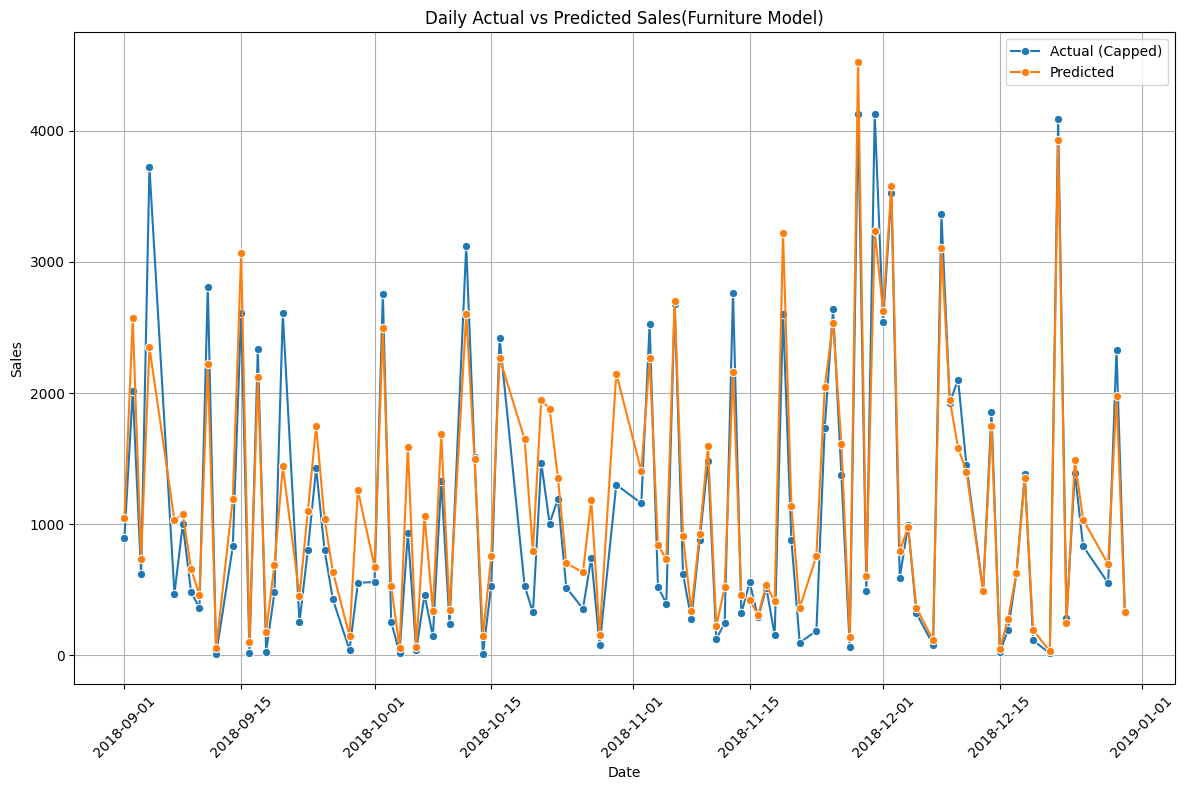

In [46]:
# Creating a DataFrame with daily actual and predicted sales
test_results = pd.DataFrame({
    'Actual': test_data_f['sales_$'].values,
    'Predicted': y_pred_f,
    'year': test_data_f['order_date'].dt.year,
    'month': test_data_f['order_date'].dt.month,
    'day': test_data_f['order_date'].dt.day
})

# Grouping by year, month, and day, and sum the actual and predicted sales
daily_sales = test_results.groupby(['year', 'month', 'day']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Creating a capped version of Actual without changing the data scale
second_max_value = daily_sales['Actual'].nlargest(2).iloc[-1]
daily_sales['Actual_capped'] = daily_sales['Actual'].clip(upper=second_max_value)

# Print the shape of the resulting DataFrame (optional)
print(daily_sales.shape)

# Creating a date column for plotting
daily_sales['date'] = pd.to_datetime(daily_sales[['year', 'month', 'day']])

# Plotting daily actual vs predicted sales
plt.figure(figsize=(12, 8))
sns.lineplot(data=daily_sales, x='date', y='Actual_capped', label='Actual (Capped)', marker='o')
sns.lineplot(data=daily_sales, x='date', y='Predicted', label='Predicted', marker='o')

# Adding titles, labels, and grid
plt.title('Daily Actual vs Predicted Sales(Furniture Model)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*4.1.3 Applying XgBoost for Technology DataSet*

In [47]:
split_date = '2018-09-01'

# Split the data into training and testing sets
train_data_t = technology_df[technology_df['order_date'] < split_date]
test_data_t = technology_df[technology_df['order_date'] >= split_date]


In [48]:
# Convert the DataFrame to NumPy arrays
train_t= train_data_t[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values
test_t = test_data_t[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values

# Separate the features (X) and target (y) for train and test
trainX_t, trainy_t = train_t[:, :-1], train_t[:, -1]
testX_t, testy_t = test_t[:, :-1], test_t[:, -1]

In [49]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Fit the model using XGBRegressor

technology_model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.01, max_depth=8,subsample = 0.8,min_child_weight= 3,colsample_bytree=0.8)

# Train the model
technology_model.fit(trainX_t, trainy_t)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
# Making predictions on the test set
y_pred_t = technology_model.predict(testX_t)
mae = mean_absolute_error(testy_t, y_pred_t)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy_t, y_pred_t, squared=False)
print(f" RMSE: {rmse}")


Mean Absolute Error (MAE): 20.457743122823832
 RMSE: 70.91133306538153


In [51]:

# Define number of days to predict
days_to_predict = 90

# Initialize a list to store future predictions
future_predictions = []

# Create a DataFrame from f_test (test set)
test_df = pd.DataFrame(test_t, columns=[
    'day_of_week_2', 'category', 'moving_avg_180', 'ema_3', 'moving_avg_365', 'ema_15', 'ema_180', 'moving_avg_90',
    'sales_lag_1', 'sales_lag_365', 'moving_avg_15', 'LFL_growth', 'sub_category', 'day_of_week_4', 'sales_$'
])

# Get the current day of the week from the last row in the DataFrame
day_of_week_columns = ['day_of_week_2', 'day_of_week_4']  # Define all day_of_week columns you're using
current_day_of_week = test_df[day_of_week_columns].iloc[-1].idxmax()  # This finds the current active day_of_week column
day_of_week_map = {'day_of_week_2': 1, 'day_of_week_4': 3}  # Map your columns to corresponding day numbers

# Inverse map to convert from day numbers back to column names
inverse_day_of_week_map = {1: 'day_of_week_2', 3: 'day_of_week_4'}  # Update with more mappings if needed

# Identify the current day of the week
current_day_of_week_num = day_of_week_map.get(current_day_of_week, 1)  # Default to 1 (day_of_week_2)

# Loop over each day to predict iteratively
for day in range(1, days_to_predict + 1):
    # Prepare the data for prediction (use the last row in the test_df as input, excluding target column 'sales_$')
    current_test_data = test_df.iloc[-1, :-1].values  # Exclude 'sales_$' (target)

    # Predict the next day's sales
    current_pred = technology_model.predict(current_test_data.reshape(1, -1))[0]

    # Append the prediction to the list of future predictions
    future_predictions.append(current_pred)

    # Create a new row for the predicted day
    new_row = test_df.iloc[-1].copy()
    new_row['sales_$'] = current_pred

    # Increment the day of the week cyclically (0 to 6)
    current_day_of_week_num = (current_day_of_week_num + 1) % 7

    # Reset all day_of_week columns to 0
    new_row[day_of_week_columns] = 0

    # Set the correct day_of_week column based on the incremented day
    if current_day_of_week_num in inverse_day_of_week_map:
        new_row[inverse_day_of_week_map[current_day_of_week_num]] = 1

    # Append the new row to allow recalculation of lag features and moving averages after appending
    test_df = pd.concat([test_df, pd.DataFrame([new_row])], ignore_index=True)

    # Recalculate the lag features after appending the new data
    test_df['sales_lag_1'] = test_df['sales_$'].shift(1)
    test_df['sales_lag_365'] = test_df['sales_$'].shift(365) if len(test_df) > 365 else np.nan

    # Recalculate moving averages based on the newly appended data
    test_df['moving_avg_180'] = test_df['sales_$'].rolling(window=180).mean() if len(test_df) >= 180 else np.nan
    test_df['moving_avg_90'] = test_df['sales_$'].rolling(window=90).mean() if len(test_df) >= 90 else np.nan
    test_df['moving_avg_15'] = test_df['sales_$'].rolling(window=15).mean() if len(test_df) >= 15 else np.nan
    test_df['moving_avg_365'] = test_df['sales_$'].rolling(window=365).mean() if len(test_df) >= 365 else np.nan

    # Recalculate exponential moving averages (EMAs) based on the newly appended data
    test_df['ema_3'] = test_df['sales_$'].ewm(span=3).mean() if len(test_df) >= 3 else np.nan
    test_df['ema_15'] = test_df['sales_$'].ewm(span=15).mean() if len(test_df) >= 15 else np.nan
    test_df['ema_180'] = test_df['sales_$'].ewm(span=180).mean() if len(test_df) >= 180 else np.nan

# Convert future_predictions to a NumPy array for further analysis
future_predictions = np.array(future_predictions)

# Output the predictions
print(f"Next 90-day sales predictions: {future_predictions}")

Next 90-day sales predictions: [ 3.9012125   1.6740272  -4.3845797  -6.772427   -3.944891    5.928664
 -4.981936   -4.7295713   3.0570228  -2.5958638   4.5804787   3.6121378
  3.1840405   7.8891716   3.0840936  -3.4019501  -5.6202097   1.0860735
 -0.88182676  2.856955    1.3881899   1.5366822  -4.259477    4.9201126
  2.001687   23.793388    6.3372035   7.9194784   1.6223003   4.2722206
 -5.1813045  -1.3595316   5.930718   17.419462   -1.3391844  31.265148
  5.196644   10.106161    0.33299428 -1.7354817  32.547173    0.89387834
 -3.7602232  29.35874    28.888983   30.65416     5.521811   -7.2856364
 31.898008   21.316353   17.499449   14.221095   23.783335   50.3678
  4.2263227  16.251867   34.160213   20.4308     33.8384      3.515405
 18.907461   39.91208    10.045002   20.166422   30.084116   21.568655
 13.59919    25.801445   12.686316    9.786878    9.248648   26.556164
 26.665379   19.423061   25.338314    8.001254   57.50571     3.499438
 11.852668   15.489289    8.906789    9.5

(111, 6)


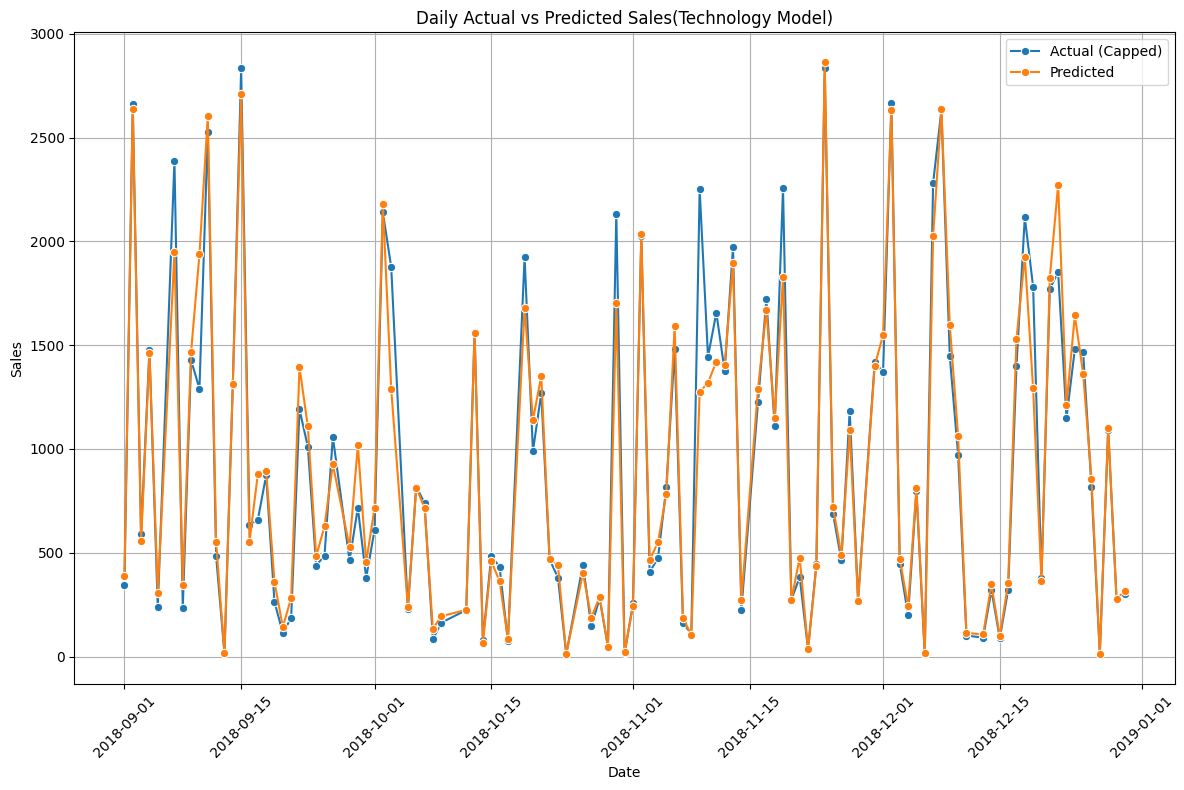

In [52]:
# Creating a DataFrame with daily actual and predicted sales
test_results = pd.DataFrame({
    'Actual': test_data_t['sales_$'].values,
    'Predicted': y_pred_t,
    'year': test_data_t['order_date'].dt.year,
    'month': test_data_t['order_date'].dt.month,
    'day': test_data_t['order_date'].dt.day
})

# Grouping by year, month, and day, and sum the actual and predicted sales
daily_sales = test_results.groupby(['year', 'month', 'day']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Creating a capped version of Actual without changing the data scale
second_max_value = daily_sales['Actual'].nlargest(2).iloc[-1]
daily_sales['Actual_capped'] = daily_sales['Actual'].clip(upper=second_max_value)

# Print the shape of the resulting DataFrame (optional)
print(daily_sales.shape)

# Creating a date column for plotting
daily_sales['date'] = pd.to_datetime(daily_sales[['year', 'month', 'day']])

# Plotting daily actual vs predicted sales
plt.figure(figsize=(12, 8))
sns.lineplot(data=daily_sales, x='date', y='Actual_capped', label='Actual (Capped)', marker='o')
sns.lineplot(data=daily_sales, x='date', y='Predicted', label='Predicted', marker='o')

# Adding titles, labels, and grid
plt.title('Daily Actual vs Predicted Sales(Technology Model)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*4.1.3 Applying XgBoost for Office Supplies*

In [53]:
split_date = '2018-09-01'

# Splitting the data into training and testing sets
train_data_o = office_df[office_df['order_date'] < split_date]
test_data_o = office_df[office_df['order_date'] >= split_date]


In [54]:
# Converting the DataFrame to NumPy arrays
train_o= train_data_o[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values
test_o = test_data_o[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values

# Separating the features (X) and target (y) for train and test
trainX_o, trainy_o = train_o[:, :-1], train_o[:, -1]
testX_o, testy_o = test_o[:, :-1], test_o[:, -1]

In [55]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Fitting the model using XGBRegressor

office_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=6)

# Training the model
office_model.fit(trainX_o, trainy_o)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
# Making predictions on the test set
y_pred_o = office_model.predict(testX_o)
mae = mean_absolute_error(testy_o, y_pred_o)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy_o, y_pred_o, squared=False)
print(f" RMSE: {rmse}")


Mean Absolute Error (MAE): 63.14648277231663
 RMSE: 128.686106375402


In [57]:
import numpy as np
import pandas as pd

# Define number of days to predict
days_to_predict = 90

# Initialize a list to store future predictions
future_predictions = []

# Create a DataFrame from f_test (test set)
test_df = pd.DataFrame(test_o, columns=[
    'day_of_week_2', 'category', 'moving_avg_180', 'ema_3', 'moving_avg_365', 'ema_15', 'ema_180', 'moving_avg_90',
    'sales_lag_1', 'sales_lag_365', 'moving_avg_15', 'LFL_growth', 'sub_category', 'day_of_week_4', 'sales_$'
])

# Loop over each day to predict iteratively
for day in range(1, days_to_predict + 1):
    # Prepare the data for prediction (use the last row in the test_df as input, excluding target column 'sales_$')
    current_test_data = test_df.iloc[-1, :-1].values  # Exclude 'sales_$' (target)

    # Predict the next day's sales
    current_pred = office_model.predict(current_test_data.reshape(1, -1))[0]

    # Append the prediction to the list of future predictions
    future_predictions.append(current_pred)

    # Create a new row for the predicted day
    new_row = test_df.iloc[-1].copy()
    new_row['sales_$'] = current_pred

    # Append the new row first to allow recalculation of lag features and moving averages after appending
    test_df = pd.concat([test_df, pd.DataFrame([new_row])], ignore_index=True)

    # Recalculate the lag features after appending the new data
    test_df['sales_lag_1'] = test_df['sales_$'].shift(1)
    test_df['sales_lag_365'] = test_df['sales_$'].shift(365) if len(test_df) > 365 else np.nan

    # Recalculate moving averages based on the newly appended data
    test_df['moving_avg_180'] = test_df['sales_$'].rolling(window=180).mean() if len(test_df) >= 180 else np.nan
    test_df['moving_avg_90'] = test_df['sales_$'].rolling(window=90).mean() if len(test_df) >= 90 else np.nan
    test_df['moving_avg_15'] = test_df['sales_$'].rolling(window=15).mean() if len(test_df) >= 15 else np.nan
    test_df['moving_avg_365'] = test_df['sales_$'].rolling(window=365).mean() if len(test_df) >= 365 else np.nan

    # Recalculate exponential moving averages (EMAs) based on the newly appended data
    test_df['ema_3'] = test_df['sales_$'].ewm(span=3).mean() if len(test_df) >= 3 else np.nan
    test_df['ema_15'] = test_df['sales_$'].ewm(span=15).mean() if len(test_df) >= 15 else np.nan
    test_df['ema_180'] = test_df['sales_$'].ewm(span=180).mean() if len(test_df) >= 180 else np.nan

    # Update the day_of_week features or other cyclical features if necessary
    # If needed, update features like 'day_of_week_2', 'day_of_week_4', etc.

# Convert future_predictions to a NumPy array for further analysis
future_predictions = np.array(future_predictions)

# Output the predictions
print(f"Next 90-day sales predictions: {future_predictions}")


Next 90-day sales predictions: [169.33684   93.59628  107.799194 119.960304 121.89203  128.55354
 120.059555 124.18194  120.80704  119.48257  123.880005 116.26496
 123.90921  117.55127  123.34887  119.07845  124.59711  117.20151
 148.8539   139.88258  133.72844  154.48358  144.54492  131.869
 132.01393  146.57393  146.1385   133.3673   133.25966  145.21234
 144.77692  133.3673   132.72292  147.65837  153.43518  137.6025
 140.41881  152.84323  149.52113  137.6025   140.41881  152.84323
 149.52113  137.6025   140.41881  152.84323  149.52113  137.6025
 140.41881  152.84323  149.52113  137.6025   140.41881  152.84323
 149.52113  137.6025   140.41881  152.84323  149.52113  137.6025
 140.41881  152.84323  149.52113  137.6025   140.41881  152.84323
 149.52113  137.6025   140.41881  152.84323  149.52113  137.6025
 140.41881  152.84323  149.52113  137.6025   140.41881  152.84323
 149.52113  137.6025   140.41881  152.84323  149.52113  137.6025
 140.41881  152.84323  149.52113  137.6025   140.418

(95, 6)


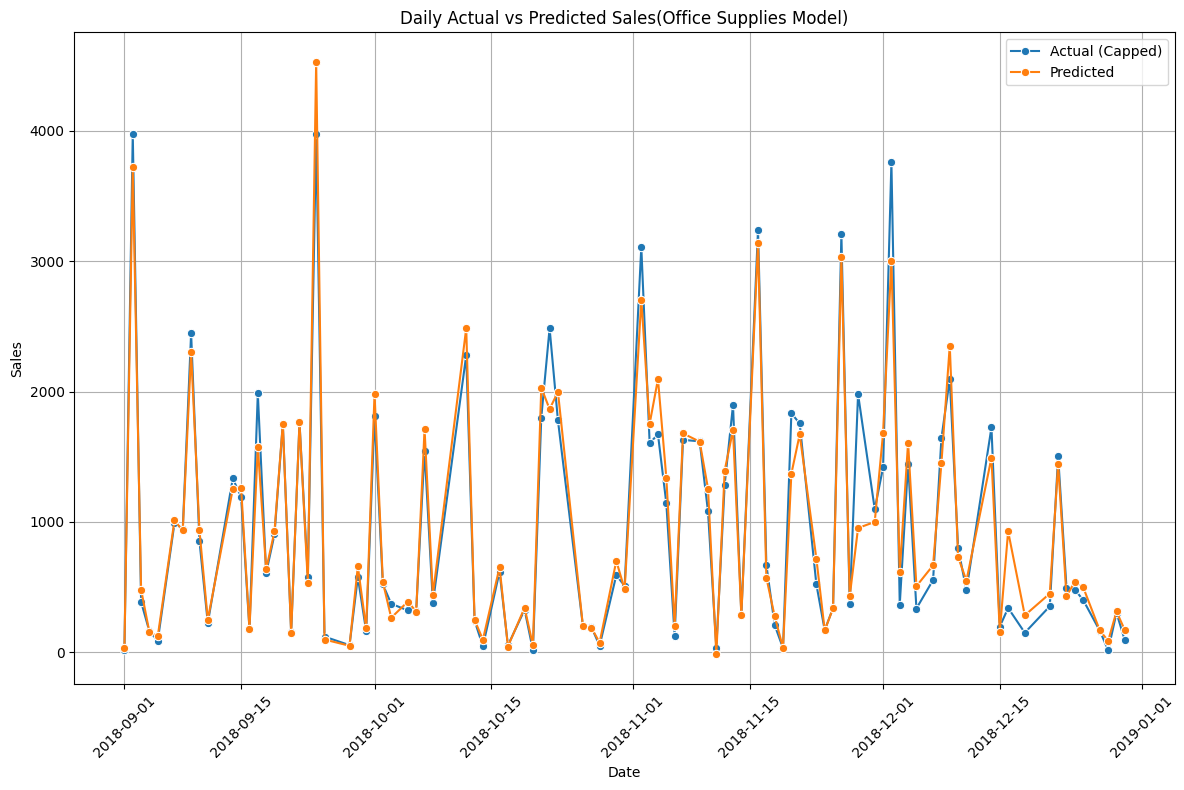

In [58]:
# Creating a DataFrame with daily actual and predicted sales
test_results = pd.DataFrame({
    'Actual': test_data_o['sales_$'].values,
    'Predicted': y_pred_o,
    'year': test_data_o['order_date'].dt.year,
    'month': test_data_o['order_date'].dt.month,
    'day': test_data_o['order_date'].dt.day
})

# Grouping by year, month, and day, and sum the actual and predicted sales
daily_sales = test_results.groupby(['year', 'month', 'day']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Creating a capped version of Actual without changing the data scale
second_max_value = daily_sales['Actual'].nlargest(2).iloc[-1]
daily_sales['Actual_capped'] = daily_sales['Actual'].clip(upper=second_max_value)

# Print the shape of the resulting DataFrame (optional)
print(daily_sales.shape)

# Creating a date column for plotting
daily_sales['date'] = pd.to_datetime(daily_sales[['year', 'month', 'day']])

# Plotting daily actual vs predicted sales
plt.figure(figsize=(12, 8))
sns.lineplot(data=daily_sales, x='date', y='Actual_capped', label='Actual (Capped)', marker='o')
sns.lineplot(data=daily_sales, x='date', y='Predicted', label='Predicted', marker='o')

# Adding titles, labels, and grid
plt.title('Daily Actual vs Predicted Sales(Office Supplies Model)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


***4.2 SARIMAX***

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare exogenous variables
exog_vars = sales_data[['sales_lag_1', 'sales_lag_7', 'sales_lag_30', 'sales_lag_365','moving_avg_3', 'moving_avg_7','LFL_growth'  ,'category','sub_category','state','ema_3','ema_7']]

# Define the SARIMAX model with exogenous variables
model = SARIMAX(sales_data['sales_$'],
                order=(1,1,2),
                exog=exog_vars,
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model_fit = model.fit()

# Print the summary
print(model_fit.summary())


In [ ]:
# Make in-sample predictions
in_sample_pred = model_fit.predict(start=0, end=len(sales_data)-1, exog=exog_vars)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE for in-sample predictions
mae = mean_absolute_error(sales_data['sales_$'], in_sample_pred)
rmse = np.sqrt(mean_squared_error(sales_data['sales_$'], in_sample_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


***4.3 Arima***

In [ ]:
split_date = '2018-09-01'
train_data_a = sales_data[sales_data['order_date'] < split_date]
test_data_a = sales_data[sales_data['order_date'] >= split_date]

# Extracting the target variable (log_sales)
train_target = train_data_a['sales_$']
test_target = test_data_a['sales_$']

In [ ]:
#Building Arima model
arima_model = ARIMA(train_target, order=(1, 1, 2))
arima_model_fit = model.fit()
print(arima_model_fit.summary())


In [ ]:
# Make in-sample predictions on the training data
in_sample_pred_a = arima_model_fit.predict(start=0, end=len(train_data_a)-1)


In [ ]:
# Calculate MAE and RMSE for in-sample predictions
mae_in_sample = mean_absolute_error(train_target, in_sample_pred_a)
rmse_in_sample = np.sqrt(mean_squared_error(train_target, in_sample_pred_a))

In [ ]:
# Print the error metrics
print(f'Mean Absolute Error (In-Sample): {mae_in_sample}')
print(f'Root Mean Squared Error (In-Sample): {rmse_in_sample}')

***5.Forecasting***

***5.1 Combined Model***

***5.2 Furniture Model***

***5.3 Technology Model***

***5.4 Office Supplies Model***